# Specific Asteroid Detection

This tool allows for a fast comparison and visualization of a specific observation and asteroid on the detector. By providing both the observation and asteroid details, the code quickly determines whether the asteroid appears in the specified observation. This tool serves as an efficient way to verify asteroid detection in a given observation, helping users quickly assess if the asteroid is visible and if it fits within the expected parameters. The results are displayed visually for easy interpretation and comparison.

## Import Libraries

In [1]:
import time
import requests
import json
import re
import os
import sys
import logging
import glob

import shapely.wkt
from shapely.geometry import Point

from PIL import Image
from sbident import SBIdent

import numpy as np
import math as mt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
from astropy.visualization import simple_norm
from datetime import datetime, timedelta

from astroquery.jplhorizons import Horizons
from astroquery.esa.jwst import Jwst

from scipy.ndimage import label

from tqdm.notebook import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

## Useful Functions

In [2]:
def MJDconversion(modifiedJulianDate):
    return Time(modifiedJulianDate, format='mjd').iso  # Extract only the date (YYYY-MM-DD)

In [3]:
class HiddenPrints:
    # Does not produce print outputs, used for built in functions with noisy print statmeents
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
def pullWCS(imagePath):
    # Open fits image, retireving header information (including WCS) and image array
    with fits.open(imagePath) as hdul:
        main_header = hdul[0].header
        
        header = hdul[1].header
        data = hdul[1].data
        
        wcs_info = WCS(header)
    
    return(data, header, wcs_info, main_header)

In [5]:
def definePolyEdges(polyString):
    # Define the image boundaries for the cone search
    # NOTE: the cone search takes RA and DEC bounds so image bounds are aligned with the DEC and RA axis (using the min,max bounds)
    
    # Deconstruct the polygon string into its RA and DEC coordinates 
    coordinates = polyString.replace("POLYGON ((", "").replace("))", "").replace(", ", " ").split()
    coordinates = list(map(float, coordinates))
    
    RA_elements = coordinates[::2]
    DEC_elements = coordinates[1::2]
    
    # Add in a small buffer around the image 
    buffer = 0.005  #Deg

    # Identify the max/min boundary range of the image by identifying 2 corners of the image
    low_right_corner = SkyCoord(min(RA_elements) - buffer, min(DEC_elements) - buffer, frame='icrs', unit='deg')
    up_left_corner   = SkyCoord(max(RA_elements) + buffer, max(DEC_elements) + buffer, frame='icrs', unit='deg')
    
    return([low_right_corner, up_left_corner])   

In [6]:
def formatPolygon(polyString):
    # Format the archive polygon string to a format that is compatible with the shapely function
    #slice away the polygon charactors 'polygon((' from the start and '))' from the end
    coords = polyString[8:-2].split(' ')
    
    #Add in the fist location at the end to close the 4 point region, shapely expects 5 coordinates
    coords.append(coords[0])
    coords.append(coords[1])
    
    return f"POLYGON (({', '.join([coords[i] + ' ' + coords[i+1] for i in range(0, len(coords), 2)])}))"

In [7]:
def expProbeTime(expStartMJD, expEndMJD):
    probe_time = (1 / 3) / 24  # 20 minutes in days
    exposure_duration = expEndMJD - expStartMJD  # Total exposure duration

    # Initialize probe list
    if exposure_duration > probe_time:
        probe_list = []
        probe = expStartMJD
        
        # Generate probe points
        while probe < expEndMJD:
            probe_list.append(MJDconversion(probe))  # Convert each probe point to YYYY-MM-DD
            probe += probe_time  # Increment probe by 20 minutes
    else:
        # Use the midpoint if exposure is less than or equal to one probe time
        midpoint = expStartMJD + exposure_duration / 2
        probe_list = [MJDconversion(midpoint)]

    return probe_list

In [8]:
def checkDataExists(proposal, observation):
    # Check if the observation is on Datalabs
    jwst_file = f"jw0{next(c for c in proposal if c != '0')}"
    dataPath = f'/data/user/jwst_{jwst_file}/jw0{proposal}/{observation}_i2d.fits.gz'    
    return (os.path.exists(dataPath), dataPath)   

## Output Image Generation

In [9]:
def produceOverlayImage(imageData, WCS, obsID, asteroidList, Xlist, Ylist):
    # Produce and save the full observation image with identification region for known asteroids, and cutout subplots
    
    # Parameters for subplot size
    subplot_width = 8  # Width of each subplot
    subplot_height = 8  # Height of each subplot
    n_subplots = len(asteroidList) + 1  # Number of subplots

    # Calculate the total figure size
    fig_width = subplot_width * n_subplots
    fig_height = subplot_height

    
    # Set figure size based on the number of asteroids, each getting their own subplot
    fig, axes = plt.subplots(1, n_subplots, figsize=(fig_width, fig_height), subplot_kw={'projection': WCS})
    
    # First subplot is for the full observation image with bounding box around asteroid
    ax1 = axes[0]  
    ax1.set_xlabel('RA')
    ax1.set_ylabel('DEC')
    ax1.set_title(f'{obsID},  i2d Image')

    # Normalize image data for better presentation
    norm = simple_norm(imageData, 'sqrt')
    ax1.imshow(imageData, cmap='viridis', norm=norm, aspect='auto', zorder=1)

    # Define asteroid-specific colors for plotting, these must contrast the background well (max = 13 asteorids in an image)
    colors = ['orangered', 'maroon', 'firebrick', 'goldenrod', 'tomato', 'chocolate', 
              'tab:red', 'tab:orange', 'red', 'orange',  'black', 'yellow', 'blueviolet']

    # Loop through asteroids and overlay positions, each getting their own subplot cutout and overlay
    for indx, asteroid in enumerate(asteroidList):
        ax_ = axes[indx + 1] 
        ax_.set_xlabel('RA')
        ax_.set_ylabel('DEC')
        ax_.set_title(f'{obsID} Asteroid {asteroid}')
        

        # Define X and Y positions of the enclosed Asteroids
        X = Xlist[indx]
        Y = Ylist[indx]
        
        # Add buffer space around the asteroid position
        extraPixels = 20  

        # Get positions of the asteroid bounds for crop region
        if len(X) > 1:
            P1 = [X[0], Y[0]]
            P2 = [X[-1], Y[-1]]
        else:
            P1 = [X[0], Y[0]]
            P2 = [X[0], Y[0]]

        # Define the default bounds with extra space 
        lowerx = round(min(P1[0], P2[0])) - extraPixels
        upperx = round(max(P1[0], P2[0])) + extraPixels
        lowery = round(min(P1[1], P2[1])) - extraPixels
        uppery = round(max(P1[1], P2[1])) + extraPixels
        
        rows, cols = imageData.shape

        # Calculate crop boundaries with bounds checking using numpy.clip and additional buffer pixels
        col_start, col_end = np.clip([lowerx, upperx], 0, cols - 1)
        row_start, row_end = np.clip([lowery, uppery], 0, rows - 1)
        
        # Extract cropped region
        cropped_image = imageData[row_start:row_end, col_start:col_end]
        
        # Normalize image data for better presentation
        ax_.imshow(cropped_image, cmap='viridis', zorder=1)

        # Plot the bounding box and asteroid positions
        ax1.plot([lowerx, upperx, upperx, lowerx, lowerx], 
                 [lowery, lowery, uppery, uppery, lowery], 
                 alpha=0.7, c=colors[indx], linewidth=2, zorder=2, label=asteroid)
        
        ax_.scatter(X - col_start, Y - row_start, s=15, alpha=0.8, c=colors[indx], zorder=2, label='JPL Coordinates')
        #ax_.set_xlim(lowerx, upperx)
        #ax_.set_ylim(lowery, uppery)
        ax_.legend()

    ax1.legend()
    plt.tight_layout()
    plt.show()

## Small Body Identification Cone Search

In [10]:
def JWSTposition(obsTime):
    # Determine the position of JWST during the observation time from an Earth perspective
    # Follows example 3 from https://github.com/bengebre/sbident/blob/main/examples/sbident-examples.ipynb 
    
    #NOTE: it is likely that this value can be pulled from the image header in the future
    
    # Generate AU to km conversion
    au_to_km = (1 * u.au).to(u.km).value
    
    # Probe for the JWST output from JPL Horizons, state vector
    jwst_output = Horizons(id='JWST',location='Geocentric',epochs=obsTime.jd, id_type='id').vectors(refplane='earth')

    # Convert position and velocity from AU to km and km/s respectively
    jwst_output_km = jwst_output[['x', 'y', 'z', 'vx', 'vy', 'vz']].to_pandas().to_numpy()
    jwst_output_km[:, :3] *= au_to_km  # Convert position (x, y, z) from AU to km
    jwst_output_km[:, 3:] /= 86400     # Convert velocity (vx, vy, vz) from AU/day to km/s

    # Form the xobs dictionary that is the input for SBIdent location argument
    xobs = ','.join([f"{s:.12e}" for s in jwst_output_km[0]])
    return {'xobs': xobs}

In [11]:
def SBIDENT_coneSearch(Exptime, Edge1, Edge2):
    # Apply cone search method to identify what asteroids are present in the observation at a specific time (exp time) bound by the image corners (ra, dec)
    # NOTE: unlike JPL Horizons, the sbident cone search only utilizes 1 fixed time
    
    # Convert the exposure time string into the observation time to probe the cone search
    ObsTime = Time(Exptime)
    
    # Determine the JWST position at the moment of observation
    jwstLocation = JWSTposition(ObsTime)

    # Apply the small body identification cone search method 'sbid' from https://github.com/bengebre/sbident
    try:
        sbid = SBIdent(jwstLocation, ObsTime, [Edge1, Edge2]).results
        
    except Exception as e:
        # Some times the connection gets interrupted and needs to be reran
        logging.info("Failed First Try in SBIDENT")
        logging.info(e)
        time.sleep(5)
        
        # Try again
        try:
            sbid = SBIdent(jwstLocation, ObsTime, [Edge1, Edge2]).results
        except Exception as e:
            logging.info("Failed Second Try in SBIDENT")
            logging.info(e)
            sbid = False
    
    # If the return sbid is an empty list convert it to a False boolean
    if isinstance(sbid, list) and not sbid:
        logging.info("SBIDENT Output was empty")
        sbid = False
    
    return(sbid)

In [12]:
def asteroid_cone_search(expStartMJD, expEndMJD, polyStringFormatted):
    # Return all the asteroid names within the level 3 image conesearch
    
    # Define the image bounds from the polygon
    poly_corners = definePolyEdges(polyStringFormatted)
    
    # Define the probe time for individual searches
    probeList = expProbeTime(expStartMJD, expEndMJD)
    
    asteroid_names = []
    
    # Loop over the probe times within an image and return all asteroid names from the conesearch
    for probe in probeList:
        sbid_middle_results = SBIDENT_coneSearch(probe, *poly_corners)
        
        if sbid_middle_results:
            asteroid_names.append(sbid_middle_results['Object name']) 
        else:
            # No asteroids found in the cone search
            pass
    
    # Find only uniqely contained Asteroids
    unique_asteroids = list(set(item.split('(')[-1].replace(')', '') for sublist in asteroid_names for item in sublist))

    return(unique_asteroids)

In [13]:
def asteroid_JPL_search(targetID, startTime, stopTime, polyString):
    #Search the JPL Horizons data for a specific target to get orbital values. 
    #This method is more accurate then the cone search and provides a double check for asteroids (named from the cone search) existing in the image
    
    #generate polygon variable from the polygon string
    poly_shape = shapely.wkt.loads(polyString)
    
    #define the probe minutes at its lowest setting as to not miss ny additional data
    #Note: there is likely a way to toggle this depending on the length of the exposure time as sometimes the exposure tis very long

    probeMinutes = 1
    #get return from the JPL horizons output regarding the specific target searched
    try:
        jpl_output = Horizons(
            id=targetID, 
            location='Geocentric@JWST', 
            epochs={'start': str(startTime), 'stop' : str(stopTime), 'step' : f"{probeMinutes}m"})
        
        #get Ephemerides data
        jpl_pandas = jpl_output.ephemerides().to_pandas()
        
    except Exception as e:
        logging.info(f"JPL Horizons Failed to retrieve data for {targetID}, Trying again")
        time.sleep(30)
        
        try:           
            jpl_output = Horizons(
            id=targetID, 
            id_type='smallbody',
            location='Geocentric@JWST', 
            epochs={'start': str(startTime), 'stop' : str(stopTime), 'step' : f"{probeMinutes}m"}) 
            
            #get Ephemerides data
            jpl_pandas = jpl_output.ephemerides().to_pandas()
            
        except Exception as e:
            logging.info(f"JPL Horizons Failed Second Try for {targetID}")
            logging.info(e)
            return(False, False)     
    
    #check to see if there are any times during this that the asteroid intercepts with the imaging window
    return (any(poly_shape.contains(Point(ra, dec)) for ra, dec in zip(jpl_pandas['RA'], jpl_pandas['DEC'])), jpl_pandas)

In [14]:
def total_asteroid_search(row, asteroid_ID_list):
    #Begin the asteroid search process 
    
    proposal = row['proposal_id']
    observation = row['observationid']
    polygonString = row['position_bounds_spoly']
    expStartMJD = row['time_bounds_lower']
    expEndMJD = row['time_bounds_upper']
    filter_name =   row['energy_bandpassname']

    #convert the format of the polygon string
    poly_string_formatted = formatPolygon(str(polygonString))
    
    #Convert Exp Time to proper Format
    expStart = (MJDconversion(expStartMJD))
    expEnd   = (MJDconversion(expEndMJD))
    
    contained_check = []
    asteroid_IDs = []
    asteroid_RA = []
    asteroid_DEC = []
    
    asteroid_contained = []
    asteroidX = []
    asteroidY = []
    
    image_on_datalabs, dataPath = checkDataExists(proposal, observation)
    
    print(f"Image Exists on Datalabs : {image_on_datalabs}")
    
    if image_on_datalabs:
        if asteroid_ID_list == False:
            print("Finding Asteroids")
            asteroid_ID_list = asteroid_cone_search(expStartMJD, expEndMJD, poly_string_formatted)
        
        print("Pulling Image Data")
        imageData, header, WCS, main_header = pullWCS(dataPath)

        print("Checking Which Asteroids Are In the Image")
        for asteroidID in asteroid_ID_list:
            containedCheck, asteroid_ephem = asteroid_JPL_search(asteroidID, expStart, expEnd, poly_string_formatted)
            
            contained_check.append(containedCheck)
            asteroid_IDs.append(asteroidID)
            asteroid_RA.append(float(asteroid_ephem['RA']))
            asteroid_DEC.append(float(asteroid_ephem['DEC']))
            
            if containedCheck:
                asteroidPixelX, asteroidPixelY = WCS.all_world2pix(asteroid_ephem['RA'], asteroid_ephem['DEC'], 0)
                asteroid_contained.append(asteroidID)
                asteroidX.append(asteroidPixelX)
                asteroidY.append(asteroidPixelY)
                
     
    results_df = pd.DataFrame({
        "Asteroid Name": asteroid_IDs,
        "Asteroid RA": asteroid_RA,
        "Asteroid DEC": asteroid_DEC,
        "Asteroid Contained": contained_check
    })

    # Print the DataFrame
    
    print('\n---------------------------------------------------------')
    print('Proposal',proposal)
    print('Observation',observation)
    print('Polygon',polygonString)
    print('Exposure Start',expStartMJD)
    print('Exposure End',expEndMJD)
    print('Filter',filter_name)
    print(' ')
    print(results_df)
    
    produceOverlayImage(imageData, WCS, observation, asteroid_contained, asteroidX, asteroidY)

In [15]:
def main(query_filters, asteroid_name_list = False):
    
    pd.set_option('display.max_rows', None)  
    pd.set_option('display.width', 2000)
    
    with HiddenPrints():     
        # Define the readouts and query filters
        readouts = [
            'proposal_id', 'observationid', 'dataproducttype', 'intent',
            'target_moving', 'energy_bandpassname',
            'position_bounds_spoly', 'time_bounds_lower', 'time_bounds_upper'
        ]

        # Construct the ADQL query string
        query_string = f"SELECT {', '.join(readouts)} FROM jwst.archive WHERE ({' AND '.join(query_filters)})"
    
        # Execute the query and retrieve results
        job = Jwst.launch_job(query_string, async_job=True)
        result = job.get_results()
        df = result.to_pandas()
    
    df.progress_apply(lambda row: total_asteroid_search(row, asteroid_name_list), axis=1)

  0%|          | 0/1 [00:00<?, ?it/s]

Image Exists on Datalabs : True
Finding Asteroids
Pulling Image Data
Checking Which Asteroids Are In the Image

---------------------------------------------------------
Proposal 1522
Observation jw01522002001_02105_00001_mirimage
Polygon Polygon 235.3390542240001 -19.19660709999998 235.35478721099986 -19.201583054999976 235.34966122400013 -19.21651834699999 235.33384693900004 -19.211588607999985
Exposure Start 59774.45188188889
Exposure End 59774.45198203704
Filter F1000W
 
  Asteroid Name  Asteroid RA  Asteroid DEC  Asteroid Contained
0      1998 BC1    235.33907      -19.2048                True


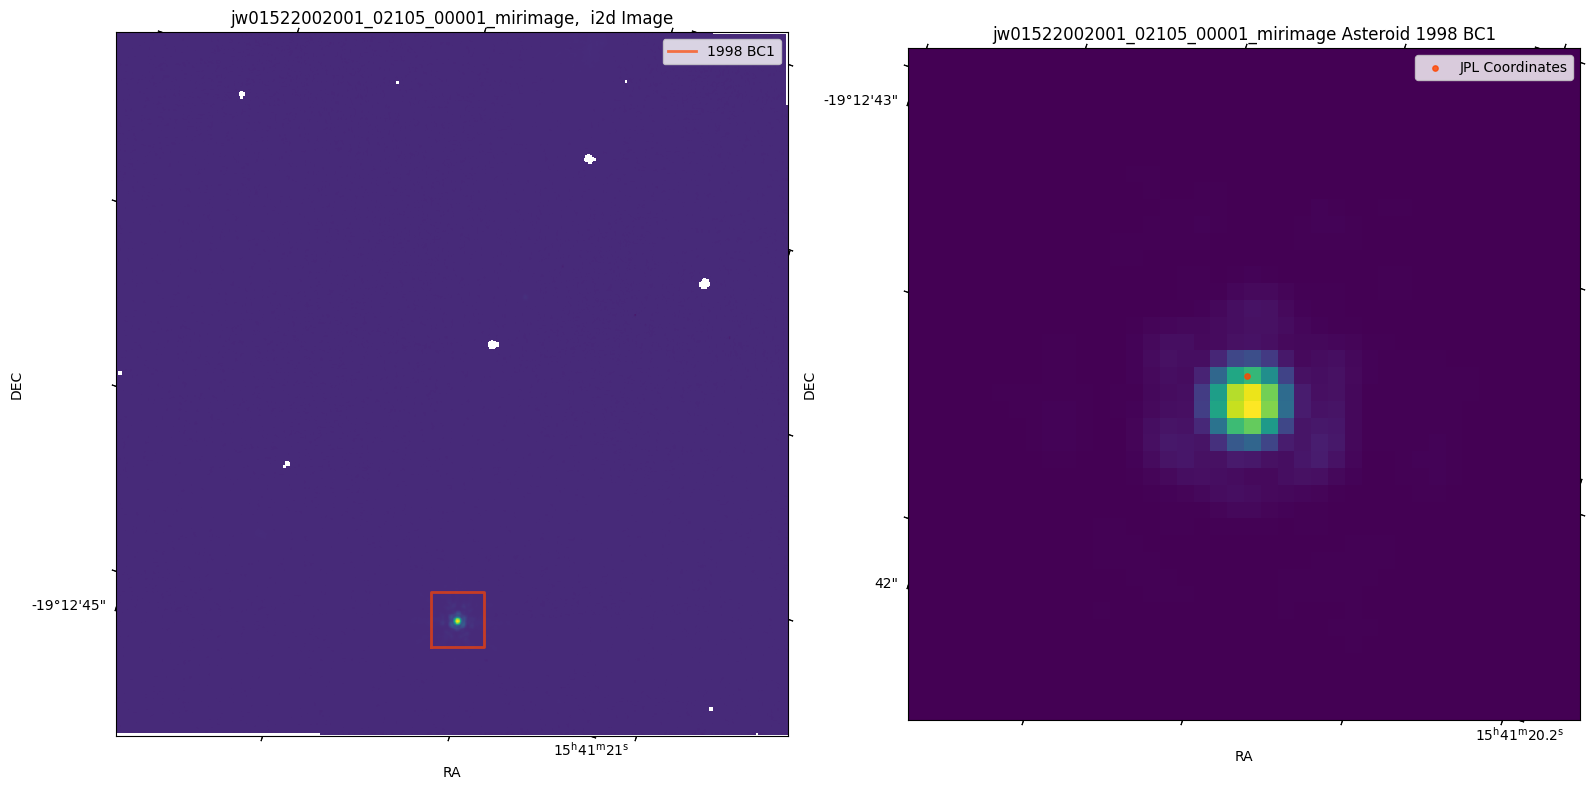

CPU times: user 696 ms, sys: 887 ms, total: 1.58 s
Wall time: 1min


In [16]:
%%time

calLVL = 2
dataType = 'image'
instrumentName = 'MIRI/IMAGE'
propID = 1522
obsID = 'jw01522002001_02105_00001_mirimage'

query_filters = [
            f'jwst.archive.calibrationlevel = {calLVL}',
            f"jwst.archive.dataproducttype = '{dataType}'",
            f"jwst.archive.instrument_name = '{instrumentName}'",
            f"jwst.archive.proposal_id = '{propID}'",
            f"jwst.archive.observationid = '{obsID}'"
        ]

main(query_filters)